<a href="https://colab.research.google.com/github/kasunJKD/nucifera_predictor/blob/main/forcast_new_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [116]:
df = pd.read_csv('Cleaned data.csv',  thousands=',')
df


,Date,(Average Price)\nRs./1000,Rainfall mm \nKurunagala,Rainfall mm\nPuththalam,Rainfall mm\nColombo,Unnamed: 5,(Average Price)\nNot rounded
0,07/01/2023,82452,56.4,50.1,58.2,NaN,82452.00
1,14/01/2023,79037,56.4,50.1,58.2,NaN,79037.00
2,21/01/2023,84117,56.4,50.1,58.2,NaN,84117.00
3,28/01/2023,80812,56.4,50.1,58.2,NaN,80812.00
4,07/02/2023,75397,98.8,43.1,72.7,NaN,75396.69
...,...,...,...,...,...,...,...
219,28/11/2018,37000,350.4,205.5,420.7,NaN,37000.00
220,07/12/2018,36000,99.4,74.4,139.5,NaN,36000.00
221,14/12/2018,36000,99.4,74.4,139.5,NaN,36000.00
222,21/12/2018,36000,99.4,74.4,139.5,NaN,36000.00


In [117]:
td = pd.to_datetime(df['Date'], dayfirst=True)
train_dates = td.sort_values(ascending=False)
train_dates

15    2023-04-28
14    2023-04-21
13    2023-04-14
12    2023-04-07
11    2023-03-28
         ...    
184   2018-03-07
183   2018-02-28
182   2018-02-21
181   2018-02-14
180   2018-02-07
Name: Date, Length: 224, dtype: datetime64[ns]

In [118]:
cols = list(df)[1:5]
print(cols)
df_for_training = df[cols].astype(float)

['(Average Price)\nRs./1000', 'Rainfall mm \nKurunagala', 'Rainfall mm\nPuththalam', 'Rainfall mm\nColombo']


In [119]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [120]:
trainX = []
trainY = []

n_future = 4   # Number of weeks we want to look into the future based on the past weeks.
n_past = 20  # Number of past weeks we want to use to predict the future.

In [121]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (201, 20, 4).
trainY shape == (201, 1).


In [122]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 20, 64)            17664     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
12/12 [==============================] - 4s 72ms/step - loss: 0.6207 - val_loss: 0.3083
Epoch 2/5
12/12 [==============================] - 0s 31ms/step - loss: 0.3847 - val_loss: 0.1414
Epoch 3/5
12/12 [==============================] - 0s 33ms/step - loss: 0.3144 - val_loss: 0.1675
Epoch 4/5
12/12 [==============================] - 0s 33ms/step - loss: 0.2901 - val_loss: 0.1250
Epoch 5/5
12/12 [==============================] - 0s 32ms/step - loss: 0.2903 - val_loss: 0.1348


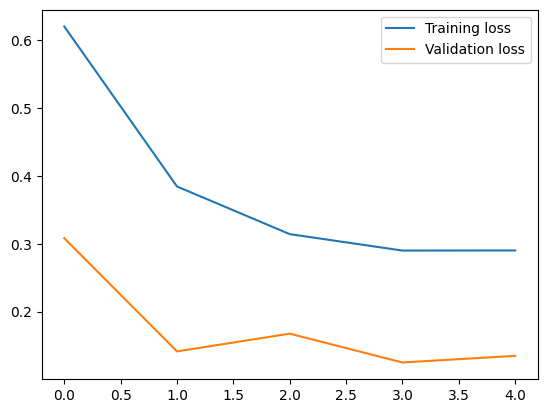

In [123]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [124]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [125]:
n_past = 1
n_weeks_for_prediction=4
#prediction period should be from 2023 5 1 - 7- 14 - 21 - 27
predict_period_dates = pd.date_range(list(train_dates)[n_past], periods=n_weeks_for_prediction, freq='W-SUN').tolist()
predict_period_dates

# import pandas as pd
# from dateutil.relativedelta import relativedelta

# # Define the start and end dates
# start_date = '2023-06-15'
# end_date = '2023-12-31'

# # Convert start_date to a pandas Timestamp
# start_date = pd.Timestamp(start_date)

# # Adjust the start_date to the first day of the next month if it falls in the middle of a month
# if start_date.day > 1:
#     start_date = start_date + relativedelta(day=1, months=1)

# # Generate a range of dates from start to end
# dates = pd.date_range(start=start_date, end=end_date, freq='D')

# # Create a DataFrame with the dates
# df = pd.DataFrame({'Date': dates})

# # Extract the year and month from the date
# df['Year'] = df['Date'].dt.year
# df['Month'] = df['Date'].dt.month

# # Group the dates by year and month
# grouped = df.groupby(['Year', 'Month'])

# # Get the list of specific dates within the weeks of each month
# dates_per_month = grouped.apply(lambda x: x[x['Date'].dt.day.isin([7, 14, 21, 27])]['Date'].tolist())

# print(dates_per_month)

[Timestamp('2022-07-03 00:00:00', freq='W-SUN'),
 Timestamp('2022-07-10 00:00:00', freq='W-SUN'),
 Timestamp('2022-07-17 00:00:00', freq='W-SUN'),
 Timestamp('2022-07-24 00:00:00', freq='W-SUN')]

In [126]:
prediction = model.predict(trainX[-n_weeks_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 384ms/step


In [127]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
y_pred_future

array([39940.74 , 41086.45 , 42068.07 , 42910.605], dtype=float32)

In [128]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), '(Average Price)\nRs./1000':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'], dayfirst=True)

<ipython-input-129-c6906e4c13c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'], dayfirst=True)


<Axes: xlabel='Date', ylabel='(Average Price)\nRs./1000'>

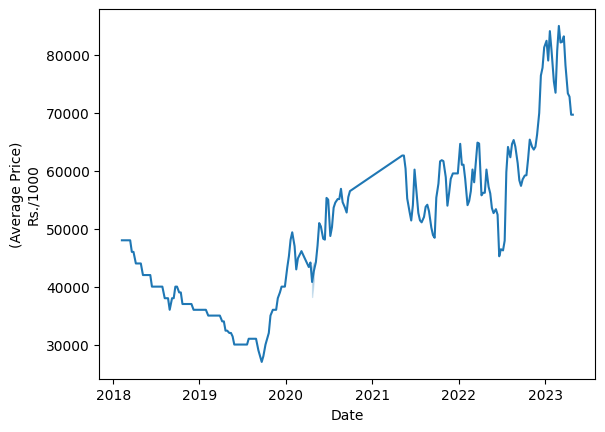

In [129]:
original = df[['Date', '(Average Price)\nRs./1000']]
original.head
original['Date']=pd.to_datetime(original['Date'], dayfirst=True)
#original = original.loc[original['Date'] >= '07/05/2020']

sns.lineplot(x=original['Date'], y=original['(Average Price)\nRs./1000'])
#sns.lineplot(x=df_forecast['Date'], y=df_forecast['(Average Price)\nRs./1000'])